In [1]:
# data processing packages
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

# deep learning packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import load_model

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

# model evaluation packages
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

# plot packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# load data
path = '/Users/yunxuanli/Documents/Caltechphd/research/DarkMatter/darkphoton_learning/candidate_selection/data/'
signal_2l = pd.read_hdf(path+'signaltable_2l.hdf', 'signal')
signal_4l = pd.read_hdf(path+'signaltable_4l.hdf', 'signal')
signal_6l = pd.read_hdf(path+'signaltable_6l.hdf', 'signal')
signal = pd.concat([signal_2l, signal_4l, signal_6l], ignore_index=True)


Using Theano backend.


In [2]:
# separate datasets to explore, train, valid, test, backup
index_list = np.unique(signal.eid)
index_list, index_explore = train_test_split(index_list, test_size = 100000, random_state=42)
index_list, index_train = train_test_split(index_list, test_size = 500000, random_state=42)
index_list, index_valid = train_test_split(index_list, test_size = 100000, random_state=42)
index_backup, index_test = train_test_split(index_list, test_size = 100000, random_state=42)

signal_explore = signal[signal.eid.isin(index_explore)]
signal_train = signal[signal.eid.isin(index_train)]
signal_valid = signal[signal.eid.isin(index_valid)]
signal_test = signal[signal.eid.isin(index_test)]
signal_backup = signal[signal.eid.isin(index_backup)]

signal_explore.to_hdf('./data/signal_explore.hdf','signal')
signal_train.to_hdf('./data/signal_train.hdf','signal')
signal_valid.to_hdf('./data/signal_valid.hdf','signal')
signal_test.to_hdf('./data/signal_test.hdf','signal')
signal_backup.to_hdf('./data/signal_backup.hdf','signal')

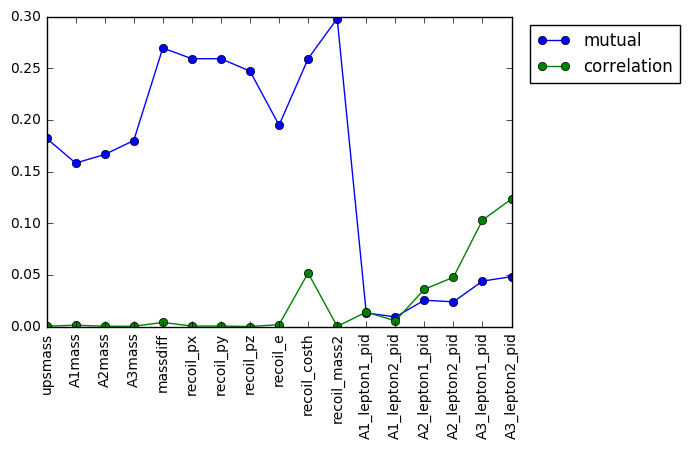

In [9]:
# separate to train and test sets
feature_name = signal.columns.tolist()
feature_name.remove('eid')
feature_name.remove('truth_matching')
feature_name.remove('upsmcmass')
feature_name.remove('A1mcmass')
feature_name.remove('A2mcmass')
feature_name.remove('A3mcmass')

X_explore = signal_explore[feature_name]
y_explore = signal_explore['truth_matching']

# mutual_score
# problem: difference between mutual information and AUC

mutual = []
correlation = []
for attr in feature_name:
    mutual.append(mutual_info_score(X_explore[attr], y_explore))
    correlation.append(abs(pearsonr(X_explore[attr], y_explore)[0]))

plt.plot(range(len(feature_name)), mutual, '-o', label='mutual')
plt.plot(range(len(feature_name)), correlation, '-o', label='correlation')
plt.xticks(range(len(feature_name)), feature_name, rotation='vertical')
plt.legend(bbox_to_anchor=[1.38,1])

In [51]:
# model definiiton and training
model = Sequential([Dense(100, input_dim=17),
                    Activation('relu'),
                    Dense(1),
                    Activation('sigmoid'),
                    ])
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])


# training: NN
weight = np.zeros(y_train.shape)
weight = weight + 1
weight[y_train==1] = y_train.shape[0] / sum(y_train)

model.fit(X_train, y_train, nb_epoch=1, batch_size=X_train.shape[0], sample_weight=weight)
model.save('nn.h5')

"""
clf_lg = LogisticRegressionCV()
clf_lg.fit(X_train, y_train, sample_weight=weight)
joblib.dump(clf_lg,'./models/lg.pkl')

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train, sample_weight=weight)
joblib.dump(clf_dt,'./models/dt.pkl')

clf_gbdt = GradientBoostingClassifier(n_estimators=100)
clf_gbdt.fit(X_train, y_train, sample_weight=weight)
joblib.dump(clf_gbdt,'./models/gbdt100.pkl')

clf_rf = RandomForestClassifier(n_estimators=30)
clf_rf.fit(X_train, y_train, sample_weight=weight)
joblib.dump(clf_rf,'./models/rf10.pkl')
"""

/Users/yunxuanli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Epoch 1/1


IndexError: indices are out-of-bounds

/Users/yunxuanli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


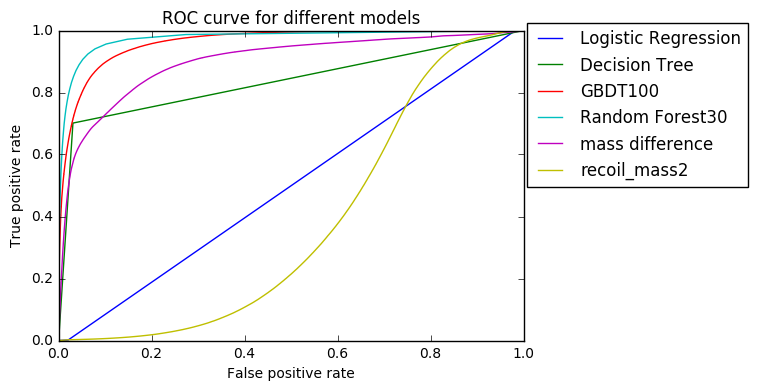

In [72]:
# performance evaluation
# ROC curve 
weight_test = np.zeros(y_test.shape)
weight_test = weight_test + 1
weight_test[y_test==1] = y_test.shape[0] / sum(y_test)

name_list = ['Logistic Regression', 'Decision Tree', 'GBDT100', 'Random Forest30']
model_list = []
model_list.append(clf_lg)
model_list.append(clf_dt)
model_list.append(clf_gbdt)
model_list.append(clf_rf)

for i in range(len(model_list)):
    m = model_list[i]
    fpr,tpr,thresholds = roc_curve(y_test, m.predict_proba(X_test)[:,1], sample_weight=weight_test)
    plt.plot(fpr, tpr, label=name_list[i])
#rf = load_model('/Users/yunxuanli/Documents/Caltechphd/research/DarkMatter/darkphoton_learning/parametercut/models/nn.h5')
#fpr,tpr,thresholds = roc_curve(y_test, rf.predict(X_test), sample_weight=weight_test)
#plt.plot(fpr, tpr, label='Neural Network')

fpr,tpr,thresholds = roc_curve(y_test, -X_test.massdiff, sample_weight=weight_test)
plt.plot(fpr, tpr, label='mass difference')

fpr,tpr,thresholds = roc_curve(y_test, X_test.recoil_mass2, sample_weight=weight_test)
plt.plot(fpr, tpr, label='recoil_mass2')


plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('ROC curve for different models')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [1]:
# efficiency
X_test

NameError: name 'X_test' is not defined